# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples

In [1]:
TGT='Reply'
PRFX='Reply0405_4'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(1e5)#int(1e5)
trnsz = int(1e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.set_verbosity(optuna.logging.ERROR)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(100000, 24)


retwt          0.11211
reply          0.02754
like           0.43929
retwt_cmmnt    0.00801
dtype: float64

CPU times: user 722 ms, sys: 92.2 ms, total: 814 ms
Wall time: 814 ms


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(370000, 24)


retwt          0.112570
reply          0.028143
like           0.438841
retwt_cmmnt    0.007565
dtype: float64

CPU times: user 2.79 s, sys: 316 ms, total: 3.1 s
Wall time: 3.11 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(100000, 24) 0.10413
370000 10413 100000 10413


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
5,101\t1434\t107854\t18260\t31904\t111431\t74759...,NaN,0EB15633A8CC0A6E3917C272F43E6DF3,NaN,NaN,NaN,TopLevel,022EC308651FACB02794A8147AEE1B78,1581218899,A7E00C86B4E3709D589754A51042A360,1198215,662,True,1246548812,016212C070A76EAB37E8ED93CA509BA9,0,42,False,1578271262,False,False,True,False,False
51,101\t10473\t10116\t10132\t12603\t97953\t25307\...,NaN,7C71C144E7B9F2D87F1F4DDB40AB1C49,NaN,NaN,NaN,TopLevel,2996EB2FE8162C076D070A4C8D6532CD,1581203618,B0CBECD53C3B945C875C55DDFF56D13F,1424,854,False,1394906655,01625341E5A48963E5AA7DFFDC4436D4,643,327,False,1372760933,True,False,True,False,False
63,101\t56898\t137\t24362\t131\t100\t196\t36351\t...,NaN,ADCF033A7C7087C1506E2BC3E2D8F092,NaN,NaN,NaN,Retweet,717293301FE296B0B61950D041485825,1581258397,ECD90FC37F0A7C15C82834FDDEEDC21A,1753,811,False,1568347799,01625CCEC5A4C322FC247DB9E223CC08,147,1355,False,1355850070,False,False,True,False,False
75,101\t12441\t105702\t793\t61783\t34022\t60578\t...,NaN,7EB0824DDA3D28844CC0FF65B7C4AA08,NaN,NaN,NaN,TopLevel,167115458A0DBDFF7E9C0C53A83BAC9B,1581271814,D905F31F909CC63C2BBEB7F6B43487FE,175998,116,False,1466830888,01626B64A2570C2807AB97716262FBA9,90,139,False,1364278366,False,False,True,False,False
83,101\t69532\t10107\t12372\t10160\t19048\t136\t1...,NaN,0A95516F028EBFF6B551DB32C4B2D1B5,Video,NaN,NaN,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581214010,88E80BAB56E6F59E4EF012A8B12D3BAE,8825,8024,False,1557262802,0162759D8908AA8C849F06086A023D85,26265,24215,False,1557422269,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    
    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-06 14:28:01 start
2020-04-06 14:28:02 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 14:28:05 freq of tags
2020-04-06 14:28:05 done
CPU times: user 4.42 s, sys: 225 ms, total: 4.64 s
Wall time: 4.59 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-06 14:28:05 start
2020-04-06 14:28:07 freq of columns using CountEncoder
2020-04-06 14:28:09 freq of tags
2020-04-06 14:28:09 done
CPU times: user 3.86 s, sys: 63.7 ms, total: 3.92 s
Wall time: 3.91 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'len_toks',
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 'has_hshtgs',
       'n_hshtgs', 'has_media', 'n_media', 'has_domns', 'n_domns', 'dayofweek',
       'hour', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twt_age',
       'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age', 'u1_fllwng_cnt_by_age',
       'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp', 'frq_lang', 'frq_u1id',
       'frq_u1_fllwing_cnt', 'frq_u1_vrfed', 'frq_u2id', 'frq_u2_fllwer_cnt',
       'frq_u2_vrfed', 'frq_u1_fllw_u2', 'frq_n_media_Photo',
       'frq_n_media_Video', 'frq_n_media_GIF', 'frq_has_hshtgs',
       'frq_n_hshtgs', 'frq_has_media', 'frq_n_media', 'frq_has_domns',
       'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2', 'frq_langhour',
       'sumfrq_hshtgs', 'maxfrq_hshtgs', 'su

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 4.73 s, sys: 0 ns, total: 4.73 s
Wall time: 4.72 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

In [16]:
dftr.dtypes

twttyp                   category
lang                     category
u1_fllwer_cnt               int64
u1_fllwing_cnt              int64
u1_vrfed                     bool
u2_fllwer_cnt               int64
u2_fllwng_cnt               int64
u2_vrfed                     bool
u1_fllw_u2                   bool
retwt                        bool
reply                        bool
like                         bool
retwt_cmmnt                  bool
len_toks                    int64
n_media_Photo               int64
n_media_Video               int64
n_media_GIF                 int64
has_hshtgs                   bool
n_hshtgs                    int64
has_media                    bool
n_media                     int64
has_domns                    bool
n_domns                     int64
dayofweek                   int64
hour                        int64
tmdlta_u2u1                 int64
tmdlta_twtu1                int64
tmdlta_twtu2                int64
twt_age                     int64
u1_age        

# model

In [17]:
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
 'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]

In [18]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [19]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,
    
}
results['params'] = params

In [20]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254914	vl's binary_logloss: 0.290511
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.265933	vl's binary_logloss: 0.289866


tune_feature_fraction, val_score: 0.289866:  14%|#4        | 1/7 [00:01<00:08,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252789	vl's binary_logloss: 0.291235
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.263793	vl's binary_logloss: 0.290178


tune_feature_fraction, val_score: 0.289866:  29%|##8       | 2/7 [00:02<00:06,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252089	vl's binary_logloss: 0.291563
Early stopping, best iteration is:
[43]	tr's binary_logloss: 0.268485	vl's binary_logloss: 0.290031


tune_feature_fraction, val_score: 0.289866:  43%|####2     | 3/7 [00:03<00:05,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250308	vl's binary_logloss: 0.291808
Early stopping, best iteration is:
[36]	tr's binary_logloss: 0.270116	vl's binary_logloss: 0.290792


tune_feature_fraction, val_score: 0.289866:  57%|#####7    | 4/7 [00:04<00:03,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248462	vl's binary_logloss: 0.291779
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.260653	vl's binary_logloss: 0.290668


tune_feature_fraction, val_score: 0.289866:  71%|#######1  | 5/7 [00:06<00:02,  1.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247009	vl's binary_logloss: 0.292208
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262671	vl's binary_logloss: 0.291171


tune_feature_fraction, val_score: 0.289866:  86%|########5 | 6/7 [00:07<00:01,  1.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244834	vl's binary_logloss: 0.293567
Early stopping, best iteration is:
[30]	tr's binary_logloss: 0.271426	vl's binary_logloss: 0.29143


tune_num_leaves, val_score: 0.289866:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259326	vl's binary_logloss: 0.290173
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.26865	vl's binary_logloss: 0.289839


tune_num_leaves, val_score: 0.289839:   5%|5         | 1/20 [00:01<00:19,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.149476	vl's binary_logloss: 0.298259
Early stopping, best iteration is:
[43]	tr's binary_logloss: 0.206401	vl's binary_logloss: 0.293407


tune_num_leaves, val_score: 0.289839:  10%|#         | 2/20 [00:04<00:31,  1.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.161947	vl's binary_logloss: 0.297233
Early stopping, best iteration is:
[43]	tr's binary_logloss: 0.214373	vl's binary_logloss: 0.29356


tune_num_leaves, val_score: 0.289839:  15%|#5        | 3/20 [00:07<00:37,  2.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.169082	vl's binary_logloss: 0.297457
Early stopping, best iteration is:
[43]	tr's binary_logloss: 0.2188	vl's binary_logloss: 0.293282


tune_num_leaves, val_score: 0.289839:  20%|##        | 4/20 [00:10<00:38,  2.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.177644	vl's binary_logloss: 0.296028
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.226275	vl's binary_logloss: 0.292548


tune_num_leaves, val_score: 0.289839:  25%|##5       | 5/20 [00:13<00:37,  2.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.183252	vl's binary_logloss: 0.294483
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.22964	vl's binary_logloss: 0.291728


tune_num_leaves, val_score: 0.289839:  30%|###       | 6/20 [00:15<00:34,  2.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.175978	vl's binary_logloss: 0.296641
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.225074	vl's binary_logloss: 0.292542


tune_num_leaves, val_score: 0.289839:  35%|###5      | 7/20 [00:18<00:33,  2.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272348	vl's binary_logloss: 0.289646
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.274464	vl's binary_logloss: 0.289396


tune_num_leaves, val_score: 0.289396:  40%|####      | 8/20 [00:19<00:25,  2.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.233583	vl's binary_logloss: 0.291447
Early stopping, best iteration is:
[63]	tr's binary_logloss: 0.2487	vl's binary_logloss: 0.290156


tune_num_leaves, val_score: 0.289396:  45%|####5     | 9/20 [00:21<00:21,  1.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.295881	vl's binary_logloss: 0.295985
[200]	tr's binary_logloss: 0.291633	vl's binary_logloss: 0.293213
[300]	tr's binary_logloss: 0.289837	vl's binary_logloss: 0.292511
[400]	tr's binary_logloss: 0.288833	vl's binary_logloss: 0.292344
[500]	tr's binary_logloss: 0.288198	vl's binary_logloss: 0.292242
[600]	tr's binary_logloss: 0.287775	vl's binary_logloss: 0.2922
[700]	tr's binary_logloss: 0.28747	vl's binary_logloss: 0.292211
Early stopping, best iteration is:
[629]	tr's binary_logloss: 0.287678	vl's binary_logloss: 0.292141


tune_num_leaves, val_score: 0.289396:  50%|#####     | 10/20 [00:23<00:20,  2.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.221833	vl's binary_logloss: 0.292433
Early stopping, best iteration is:
[57]	tr's binary_logloss: 0.243618	vl's binary_logloss: 0.290813


tune_num_leaves, val_score: 0.289396:  55%|#####5    | 11/20 [00:25<00:17,  1.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274655	vl's binary_logloss: 0.289509
[200]	tr's binary_logloss: 0.265762	vl's binary_logloss: 0.289386
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.272821	vl's binary_logloss: 0.289197


tune_num_leaves, val_score: 0.289197:  60%|######    | 12/20 [00:26<00:13,  1.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.213841	vl's binary_logloss: 0.292859
Early stopping, best iteration is:
[48]	tr's binary_logloss: 0.243177	vl's binary_logloss: 0.291297


tune_num_leaves, val_score: 0.289197:  65%|######5   | 13/20 [00:28<00:12,  1.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273318	vl's binary_logloss: 0.28953
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.275181	vl's binary_logloss: 0.289397


tune_num_leaves, val_score: 0.289197:  70%|#######   | 14/20 [00:29<00:09,  1.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24117	vl's binary_logloss: 0.291353
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.256194	vl's binary_logloss: 0.290308


tune_num_leaves, val_score: 0.289197:  75%|#######5  | 15/20 [00:30<00:07,  1.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.198741	vl's binary_logloss: 0.293066
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.239266	vl's binary_logloss: 0.290869


tune_num_leaves, val_score: 0.289197:  80%|########  | 16/20 [00:32<00:06,  1.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254175	vl's binary_logloss: 0.290508
Early stopping, best iteration is:
[64]	tr's binary_logloss: 0.263144	vl's binary_logloss: 0.290117


tune_num_leaves, val_score: 0.289197:  85%|########5 | 17/20 [00:34<00:04,  1.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286383	vl's binary_logloss: 0.290326
[200]	tr's binary_logloss: 0.282244	vl's binary_logloss: 0.289527
[300]	tr's binary_logloss: 0.279601	vl's binary_logloss: 0.289203
[400]	tr's binary_logloss: 0.276979	vl's binary_logloss: 0.289256
Early stopping, best iteration is:
[332]	tr's binary_logloss: 0.278803	vl's binary_logloss: 0.289065


tune_num_leaves, val_score: 0.289065:  90%|######### | 18/20 [00:35<00:03,  1.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.206544	vl's binary_logloss: 0.293718
Early stopping, best iteration is:
[43]	tr's binary_logloss: 0.243233	vl's binary_logloss: 0.291683


tune_num_leaves, val_score: 0.289065:  95%|#########5| 19/20 [00:37<00:01,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.235387	vl's binary_logloss: 0.291168
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.251972	vl's binary_logloss: 0.290495


tune_num_leaves, val_score: 0.289065: 100%|##########| 20/20 [00:39<00:00,  1.97s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.289065:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286857	vl's binary_logloss: 0.290769
[200]	tr's binary_logloss: 0.283704	vl's binary_logloss: 0.290116
[300]	tr's binary_logloss: 0.28173	vl's binary_logloss: 0.289757
[400]	tr's binary_logloss: 0.28009	vl's binary_logloss: 0.289588
[500]	tr's binary_logloss: 0.278555	vl's binary_logloss: 0.289363
[600]	tr's binary_logloss: 0.27712	vl's binary_logloss: 0.28918
[700]	tr's binary_logloss: 0.275683	vl's binary_logloss: 0.28898
[800]	tr's binary_logloss: 0.274492	vl's binary_logloss: 0.288955
Early stopping, best iteration is:
[765]	tr's binary_logloss: 0.274855	vl's binary_logloss: 0.288776


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  10%|#         | 1/10 [00:03<00:29,  3.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286942	vl's binary_logloss: 0.290773
[200]	tr's binary_logloss: 0.283829	vl's binary_logloss: 0.290333
[300]	tr's binary_logloss: 0.281752	vl's binary_logloss: 0.289861
[400]	tr's binary_logloss: 0.280124	vl's binary_logloss: 0.28961
[500]	tr's binary_logloss: 0.278562	vl's binary_logloss: 0.289472
Early stopping, best iteration is:
[443]	tr's binary_logloss: 0.279494	vl's binary_logloss: 0.289291


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  20%|##        | 2/10 [00:05<00:23,  2.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286533	vl's binary_logloss: 0.290296
[200]	tr's binary_logloss: 0.282781	vl's binary_logloss: 0.289859
[300]	tr's binary_logloss: 0.280485	vl's binary_logloss: 0.289407
[400]	tr's binary_logloss: 0.278409	vl's binary_logloss: 0.289299
[500]	tr's binary_logloss: 0.276541	vl's binary_logloss: 0.28921
Early stopping, best iteration is:
[458]	tr's binary_logloss: 0.277283	vl's binary_logloss: 0.289162


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  30%|###       | 3/10 [00:08<00:19,  2.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286584	vl's binary_logloss: 0.290581
[200]	tr's binary_logloss: 0.282968	vl's binary_logloss: 0.290195
[300]	tr's binary_logloss: 0.280861	vl's binary_logloss: 0.289879
[400]	tr's binary_logloss: 0.278947	vl's binary_logloss: 0.289653
[500]	tr's binary_logloss: 0.277255	vl's binary_logloss: 0.289524
Early stopping, best iteration is:
[483]	tr's binary_logloss: 0.27751	vl's binary_logloss: 0.289483


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  40%|####      | 4/10 [00:10<00:16,  2.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28808	vl's binary_logloss: 0.291263
[200]	tr's binary_logloss: 0.28509	vl's binary_logloss: 0.290658
[300]	tr's binary_logloss: 0.283203	vl's binary_logloss: 0.290448
[400]	tr's binary_logloss: 0.281821	vl's binary_logloss: 0.290215
Early stopping, best iteration is:
[348]	tr's binary_logloss: 0.282385	vl's binary_logloss: 0.29006


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  50%|#####     | 5/10 [00:12<00:11,  2.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28669	vl's binary_logloss: 0.290449
[200]	tr's binary_logloss: 0.283363	vl's binary_logloss: 0.290094
[300]	tr's binary_logloss: 0.281282	vl's binary_logloss: 0.289761
[400]	tr's binary_logloss: 0.279572	vl's binary_logloss: 0.289594
[500]	tr's binary_logloss: 0.277863	vl's binary_logloss: 0.289291
[600]	tr's binary_logloss: 0.276371	vl's binary_logloss: 0.289314
[700]	tr's binary_logloss: 0.274848	vl's binary_logloss: 0.28938
Early stopping, best iteration is:
[644]	tr's binary_logloss: 0.275591	vl's binary_logloss: 0.289217


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  60%|######    | 6/10 [00:15<00:10,  2.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28645	vl's binary_logloss: 0.290244
[200]	tr's binary_logloss: 0.28267	vl's binary_logloss: 0.289667
[300]	tr's binary_logloss: 0.28026	vl's binary_logloss: 0.289591
Early stopping, best iteration is:
[283]	tr's binary_logloss: 0.28065	vl's binary_logloss: 0.289547


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  70%|#######   | 7/10 [00:16<00:06,  2.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.287071	vl's binary_logloss: 0.2909
[200]	tr's binary_logloss: 0.283986	vl's binary_logloss: 0.290539
[300]	tr's binary_logloss: 0.281992	vl's binary_logloss: 0.290141
[400]	tr's binary_logloss: 0.280657	vl's binary_logloss: 0.289885
[500]	tr's binary_logloss: 0.279176	vl's binary_logloss: 0.289512
[600]	tr's binary_logloss: 0.277876	vl's binary_logloss: 0.289588
Early stopping, best iteration is:
[524]	tr's binary_logloss: 0.278839	vl's binary_logloss: 0.289314


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  80%|########  | 8/10 [00:19<00:04,  2.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.288206	vl's binary_logloss: 0.291399
[200]	tr's binary_logloss: 0.285409	vl's binary_logloss: 0.290875
[300]	tr's binary_logloss: 0.283536	vl's binary_logloss: 0.290216
[400]	tr's binary_logloss: 0.282204	vl's binary_logloss: 0.290123
Early stopping, best iteration is:
[336]	tr's binary_logloss: 0.28294	vl's binary_logloss: 0.289804


tune_bagging_fraction_and_bagging_freq, val_score: 0.288776:  90%|######### | 9/10 [00:20<00:02,  2.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_bagging_fraction_and_bagging_freq, val_score: 0.288402: 100%|##########| 10/10 [00:24<00:00,  2.41s/it]
tune_feature_fraction, val_score: 0.288402:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_feature_fraction, val_score: 0.288402:  33%|###3      | 1/3 [00:03<00:06,  3.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286922	vl's binary_logloss: 0.290703
[200]	tr's binary_logloss: 0.283871	vl's binary_logloss: 0.290263
[300]	tr's binary_logloss: 0.281804	vl's binary_logloss: 0.289912
[400]	tr's binary_logloss: 0.28021	vl's binary_logloss: 0.289728
[500]	tr's binary_logloss: 0.278626	vl's binary_logloss: 0.289312
[600]	tr's binary_logloss: 0.277347	vl's binary_logloss: 0.289731
Early stopping, best iteration is:
[558]	tr's binary_logloss: 0.277849	vl's binary_logloss: 0.289159


tune_feature_fraction, val_score: 0.288402:  67%|######6   | 2/3 [00:06<00:03,  3.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286815	vl's binary_logloss: 0.291076
[200]	tr's binary_logloss: 0.283844	vl's binary_logloss: 0.290698
Early stopping, best iteration is:
[147]	tr's binary_logloss: 0.285098	vl's binary_logloss: 0.29066


tune_feature_fraction, val_score: 0.288402: 100%|##########| 3/3 [00:07<00:00,  2.38s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.288402:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:   5%|5         | 1/20 [00:03<01:04,  3.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283642	vl's binary_logloss: 0.290236
Early stopping, best iteration is:
[173]	tr's binary_logloss: 0.284207	vl's binary_logloss: 0.290067


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  10%|#         | 2/20 [00:04<00:48,  2.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  15%|#5        | 3/20 [00:08<00:50,  2.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.28163	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280044	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278409	vl's binary_logloss: 0.289095
[600]	tr's binary_logloss: 0.27707	vl's binary_logloss: 0.289367
[700]	tr's binary_logloss: 0.275654	vl's binary_logloss: 0.288906
[800]	tr's binary_logloss: 0.274524	vl's binary_logloss: 0.28874
[900]	tr's binary_logloss: 0.273305	vl's binary_logloss: 0.28868
Early stopping, best iteration is:
[839]	tr's binary_logloss: 0.27403	vl's binary_logloss: 0.2885


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  20%|##        | 4/20 [00:11<00:50,  3.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283711	vl's binary_logloss: 0.29017
[300]	tr's binary_logloss: 0.281677	vl's binary_logloss: 0.28972
[400]	tr's binary_logloss: 0.280098	vl's binary_logloss: 0.289496
[500]	tr's binary_logloss: 0.278457	vl's binary_logloss: 0.289346
[600]	tr's binary_logloss: 0.277147	vl's binary_logloss: 0.289679
Early stopping, best iteration is:
[559]	tr's binary_logloss: 0.277679	vl's binary_logloss: 0.2892


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  25%|##5       | 5/20 [00:14<00:44,  2.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286878	vl's binary_logloss: 0.290625
[200]	tr's binary_logloss: 0.283651	vl's binary_logloss: 0.290173
[300]	tr's binary_logloss: 0.28167	vl's binary_logloss: 0.289848
[400]	tr's binary_logloss: 0.280107	vl's binary_logloss: 0.289648
[500]	tr's binary_logloss: 0.278456	vl's binary_logloss: 0.289369
[600]	tr's binary_logloss: 0.277082	vl's binary_logloss: 0.289502
[700]	tr's binary_logloss: 0.275654	vl's binary_logloss: 0.289181
Early stopping, best iteration is:
[675]	tr's binary_logloss: 0.276018	vl's binary_logloss: 0.289066


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  30%|###       | 6/20 [00:17<00:41,  2.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286973	vl's binary_logloss: 0.290584
[200]	tr's binary_logloss: 0.28391	vl's binary_logloss: 0.290064
Early stopping, best iteration is:
[185]	tr's binary_logloss: 0.284185	vl's binary_logloss: 0.289912


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  35%|###5      | 7/20 [00:18<00:31,  2.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283604	vl's binary_logloss: 0.28999
[300]	tr's binary_logloss: 0.281625	vl's binary_logloss: 0.289584
[400]	tr's binary_logloss: 0.28007	vl's binary_logloss: 0.289304
[500]	tr's binary_logloss: 0.278512	vl's binary_logloss: 0.289196
Early stopping, best iteration is:
[481]	tr's binary_logloss: 0.278714	vl's binary_logloss: 0.289101


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  40%|####      | 8/20 [00:20<00:28,  2.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  45%|####5     | 9/20 [00:24<00:29,  2.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  50%|#####     | 10/20 [00:27<00:29,  2.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  55%|#####5    | 11/20 [00:31<00:28,  3.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  60%|######    | 12/20 [00:34<00:26,  3.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278409	vl's binary_logloss: 0.289095
[600]	tr's binary_logloss: 0.277069	vl's binary_logloss: 0.289367
[700]	tr's binary_logloss: 0.275645	vl's binary_logloss: 0.288952
[800]	tr's binary_logloss: 0.27451	vl's binary_logloss: 0.288923
[900]	tr's binary_logloss: 0.27327	vl's binary_logloss: 0.28887
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274382	vl's binary_logloss: 0.288675


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  65%|######5   | 13/20 [00:38<00:23,  3.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.28163	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280044	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278409	vl's binary_logloss: 0.289095
[600]	tr's binary_logloss: 0.27707	vl's binary_logloss: 0.289367
[700]	tr's binary_logloss: 0.275654	vl's binary_logloss: 0.288906
[800]	tr's binary_logloss: 0.274515	vl's binary_logloss: 0.288773
[900]	tr's binary_logloss: 0.273284	vl's binary_logloss: 0.288685
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274397	vl's binary_logloss: 0.288508


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  70%|#######   | 14/20 [00:41<00:20,  3.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  75%|#######5  | 15/20 [00:45<00:17,  3.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.287205	vl's binary_logloss: 0.290628
[200]	tr's binary_logloss: 0.284206	vl's binary_logloss: 0.290113
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.284523	vl's binary_logloss: 0.289903


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  80%|########  | 16/20 [00:46<00:10,  2.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.287198	vl's binary_logloss: 0.290521
[200]	tr's binary_logloss: 0.284235	vl's binary_logloss: 0.290007
[300]	tr's binary_logloss: 0.28248	vl's binary_logloss: 0.289614
[400]	tr's binary_logloss: 0.2811	vl's binary_logloss: 0.289248
[500]	tr's binary_logloss: 0.279872	vl's binary_logloss: 0.289196
[600]	tr's binary_logloss: 0.278828	vl's binary_logloss: 0.289378
[700]	tr's binary_logloss: 0.277656	vl's binary_logloss: 0.288897
[800]	tr's binary_logloss: 0.276818	vl's binary_logloss: 0.288775
[900]	tr's binary_logloss: 0.275819	vl's binary_logloss: 0.288748
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.276747	vl's binary_logloss: 0.288571


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  85%|########5 | 17/20 [00:49<00:08,  2.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.28163	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278409	vl's binary_logloss: 0.289095
[600]	tr's binary_logloss: 0.277069	vl's binary_logloss: 0.289367
[700]	tr's binary_logloss: 0.275645	vl's binary_logloss: 0.288952
[800]	tr's binary_logloss: 0.27451	vl's binary_logloss: 0.288923
[900]	tr's binary_logloss: 0.27327	vl's binary_logloss: 0.28887
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274382	vl's binary_logloss: 0.288675


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  90%|######### | 18/20 [00:53<00:06,  3.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286857	vl's binary_logloss: 0.290502
[200]	tr's binary_logloss: 0.283718	vl's binary_logloss: 0.290148
[300]	tr's binary_logloss: 0.281732	vl's binary_logloss: 0.289831
[400]	tr's binary_logloss: 0.280231	vl's binary_logloss: 0.289504
[500]	tr's binary_logloss: 0.278724	vl's binary_logloss: 0.289554
Early stopping, best iteration is:
[480]	tr's binary_logloss: 0.278941	vl's binary_logloss: 0.289388


tune_lambda_l1_and_lambda_l2, val_score: 0.288402:  95%|#########5| 19/20 [00:55<00:02,  2.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286834	vl's binary_logloss: 0.29067
[200]	tr's binary_logloss: 0.283715	vl's binary_logloss: 0.290138
[300]	tr's binary_logloss: 0.281629	vl's binary_logloss: 0.289798
[400]	tr's binary_logloss: 0.280043	vl's binary_logloss: 0.28941
[500]	tr's binary_logloss: 0.278407	vl's binary_logloss: 0.28909
[600]	tr's binary_logloss: 0.277088	vl's binary_logloss: 0.289336
[700]	tr's binary_logloss: 0.275554	vl's binary_logloss: 0.288791
[800]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.288642
[900]	tr's binary_logloss: 0.273177	vl's binary_logloss: 0.288666
Early stopping, best iteration is:
[810]	tr's binary_logloss: 0.274306	vl's binary_logloss: 0.288402


tune_lambda_l1_and_lambda_l2, val_score: 0.288402: 100%|##########| 20/20 [00:59<00:00,  2.96s/it]
tune_min_child_samples, val_score: 0.288402:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.290691
[200]	tr's binary_logloss: 0.283681	vl's binary_logloss: 0.290349
Early stopping, best iteration is:
[148]	tr's binary_logloss: 0.285044	vl's binary_logloss: 0.290172


tune_min_child_samples, val_score: 0.288402:  20%|##        | 1/5 [00:01<00:03,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286835	vl's binary_logloss: 0.290691
[200]	tr's binary_logloss: 0.283638	vl's binary_logloss: 0.290133
[300]	tr's binary_logloss: 0.281505	vl's binary_logloss: 0.289727
[400]	tr's binary_logloss: 0.279942	vl's binary_logloss: 0.289423
[500]	tr's binary_logloss: 0.278257	vl's binary_logloss: 0.289218
[600]	tr's binary_logloss: 0.27695	vl's binary_logloss: 0.289568
Early stopping, best iteration is:
[555]	tr's binary_logloss: 0.277559	vl's binary_logloss: 0.28904


tune_min_child_samples, val_score: 0.288402:  40%|####      | 2/5 [00:03<00:04,  1.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286829	vl's binary_logloss: 0.290626
[200]	tr's binary_logloss: 0.283673	vl's binary_logloss: 0.290119
[300]	tr's binary_logloss: 0.281637	vl's binary_logloss: 0.289715
[400]	tr's binary_logloss: 0.28007	vl's binary_logloss: 0.289372
[500]	tr's binary_logloss: 0.278476	vl's binary_logloss: 0.289159
[600]	tr's binary_logloss: 0.277168	vl's binary_logloss: 0.289521
Early stopping, best iteration is:
[559]	tr's binary_logloss: 0.277621	vl's binary_logloss: 0.289068


tune_min_child_samples, val_score: 0.288402:  60%|######    | 3/5 [00:06<00:03,  1.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286829	vl's binary_logloss: 0.290626
[200]	tr's binary_logloss: 0.283773	vl's binary_logloss: 0.290249
[300]	tr's binary_logloss: 0.28187	vl's binary_logloss: 0.28994
[400]	tr's binary_logloss: 0.280443	vl's binary_logloss: 0.289565
[500]	tr's binary_logloss: 0.278903	vl's binary_logloss: 0.289426
[600]	tr's binary_logloss: 0.277639	vl's binary_logloss: 0.289626
[700]	tr's binary_logloss: 0.276233	vl's binary_logloss: 0.289112
[800]	tr's binary_logloss: 0.275196	vl's binary_logloss: 0.288908
[900]	tr's binary_logloss: 0.274072	vl's binary_logloss: 0.28879
[1000]	tr's binary_logloss: 0.272959	vl's binary_logloss: 0.288965
Early stopping, best iteration is:
[941]	tr's binary_logloss: 0.273562	vl's binary_logloss: 0.288621


tune_min_child_samples, val_score: 0.288402:  80%|########  | 4/5 [00:09<00:02,  2.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286877	vl's binary_logloss: 0.290592
[200]	tr's binary_logloss: 0.28386	vl's binary_logloss: 0.290233
[300]	tr's binary_logloss: 0.281889	vl's binary_logloss: 0.289843
[400]	tr's binary_logloss: 0.280372	vl's binary_logloss: 0.289506
[500]	tr's binary_logloss: 0.278898	vl's binary_logloss: 0.289338
[600]	tr's binary_logloss: 0.27783	vl's binary_logloss: 0.289742
Early stopping, best iteration is:
[559]	tr's binary_logloss: 0.278274	vl's binary_logloss: 0.28923


tune_min_child_samples, val_score: 0.288402: 100%|##########| 5/5 [00:12<00:00,  2.50s/it]


CPU times: user 16min 59s, sys: 22min 12s, total: 39min 12s
Wall time: 2min 31s


In [21]:
best_params

{'lambda_l1': 1.0305608608032335e-08,
 'lambda_l2': 6.548022922829412e-05,
 'num_leaves': 4,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.7534362944443258,
 'bagging_freq': 5,
 'min_child_samples': 20}

## tr vl trajec

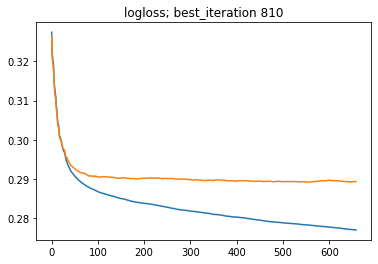

In [22]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

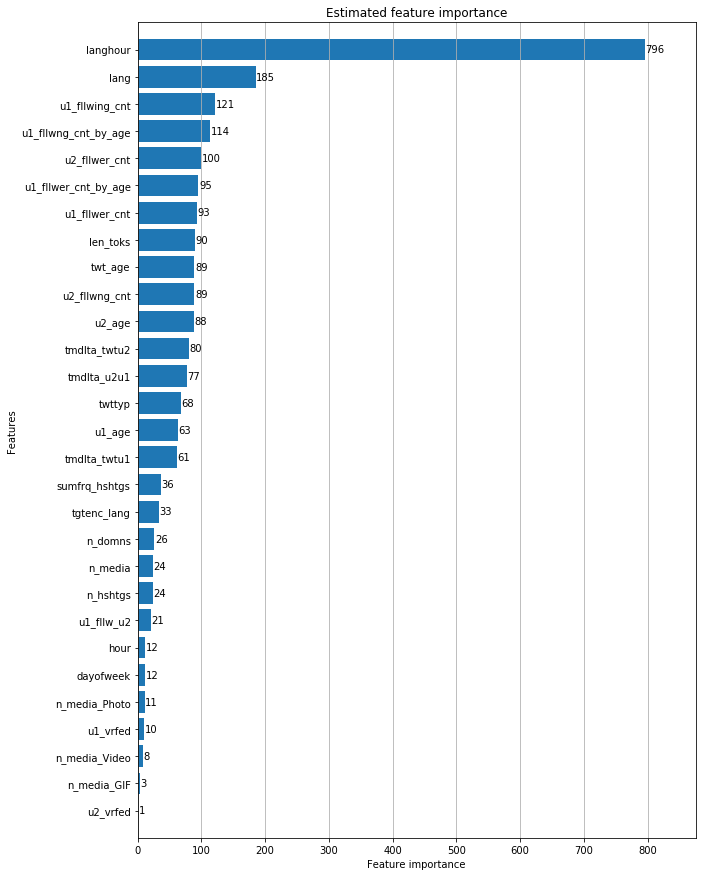

In [23]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [24]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
26,langhour,796
1,lang,185
3,u1_fllwing_cnt,121
25,u1_fllwng_cnt_by_age,114
5,u2_fllwer_cnt,100
24,u1_fllwer_cnt_by_age,95
2,u1_fllwer_cnt,93
9,len_toks,90
21,twt_age,89
6,u2_fllwng_cnt,89


# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 14.3 s, sys: 5.48 s, total: 19.8 s
Wall time: 1.5 s


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 790 ms, sys: 963 ms, total: 1.75 s
Wall time: 608 ms


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3564
auc_vl:  0.2792
auc_val: 0.0891

rce_tr:  17.9193
rce_vl:  13.4821
rce_val: 9.9675


In [28]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0891-9.9675


# save results

In [29]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [30]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [31]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 21.5 ms, sys: 115 ms, total: 136 ms
Wall time: 8.88 ms


In [32]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-06 14:30:49 start
2020-04-06 14:30:49 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 14:30:50 freq of tags
2020-04-06 14:30:50 done
CPU times: user 306 ms, sys: 922 ms, total: 1.23 s
Wall time: 159 ms


In [33]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [34]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 7.67 ms, sys: 21.1 ms, total: 28.8 ms
Wall time: 20.2 ms


In [35]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)